In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from anndata import AnnData
from pathlib import Path
import json
import imageio
from squidpy.read._utils import _load_image
from squidpy._constants._pkg_constants import Key

In [2]:
def load_data(counts_file, library_id, image_path):
    path = Path(image_path)
    
    # load count matrix
    adata = sc.read_10x_h5(counts_file)
    adata.var_names_make_unique()
    adata.uns[Key.uns.spatial] = {library_id: {}}
    
    # load image
    adata.uns[Key.uns.spatial][library_id][Key.uns.image_key] = {
        res: _load_image(path / f"tissue_{res}_image.png") for res in ["hires", "lowres"]
    }
    adata.uns[Key.uns.spatial][library_id]["scalefactors"] = json.loads((path / "scalefactors_json.json").read_bytes())
    
    # load coordinates
    coords = pd.read_csv(f"./reference/{library_id}/tissue_positions_list.txt", header=None, index_col=0)
    coords.columns = ["in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"]
    
    adata.obs = pd.merge(adata.obs, coords, how="left", left_index=True, right_index=True)
    adata.obsm[Key.obsm.spatial] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values
    adata.obs.drop(columns=["pxl_row_in_fullres", "pxl_col_in_fullres"], inplace=True)

    return adata

In [3]:
def process_data(adata, df_spatial, library_id):
    sc.pp.filter_genes(adata, min_cells=10)
    
    adata.var["mito"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    # update cell barcode
    df_meta = df_spatial.loc[df_spatial['sample_id'] == library_id][['spatialLIBD']]
    index = df_meta.index.str.split("-", expand=True).to_frame()
    df_meta.index = index[[0, 1]].apply("-".join, axis=1)
    
    adata.obs = pd.merge(adata.obs, df_meta, how="left", left_index=True, right_index=True)
    adata = adata[~adata.obs["spatialLIBD"].isna()]
    
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    
    return adata

In [4]:
df_spatial = pd.read_csv("./human_brain_10x.csv", index_col=0)
library_ids = list(df_spatial['sample_id'].unique())

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/annda

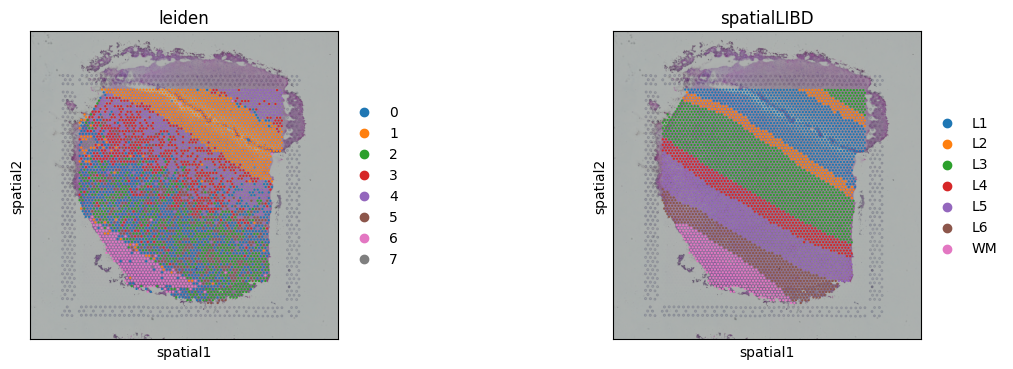

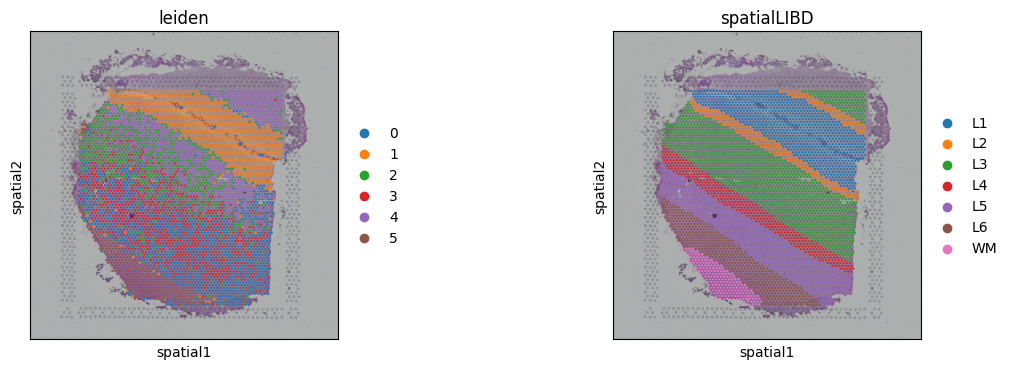

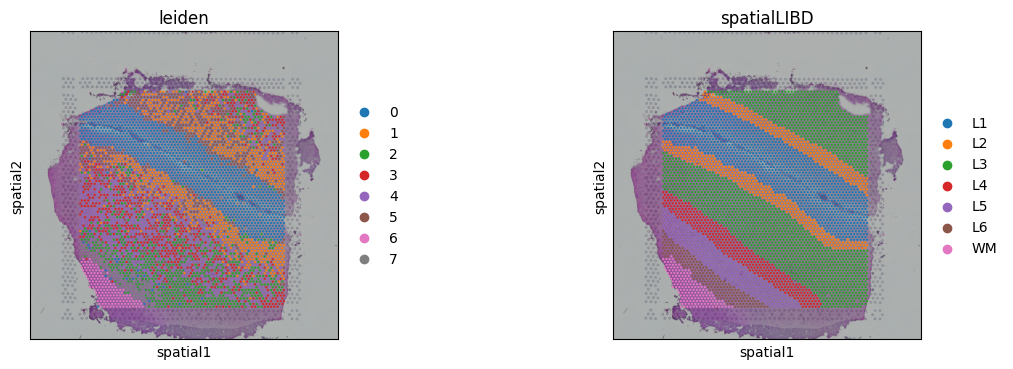

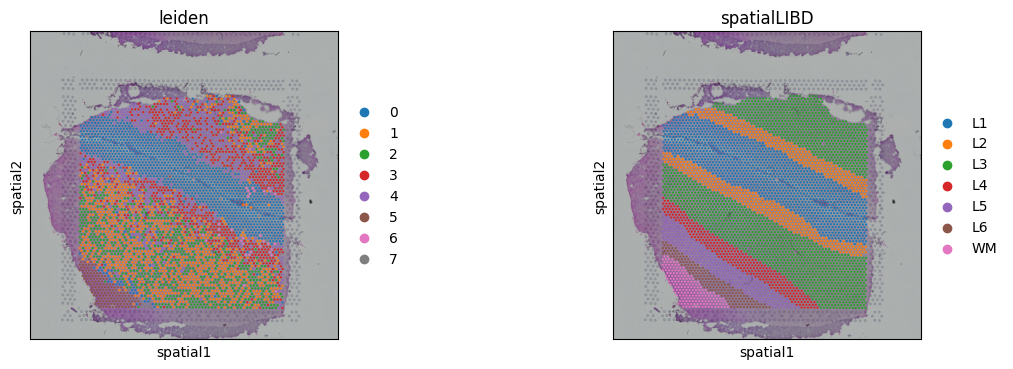

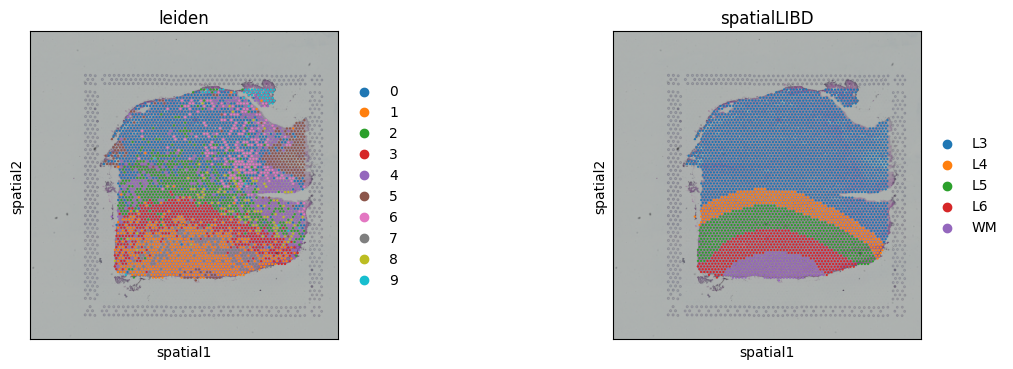

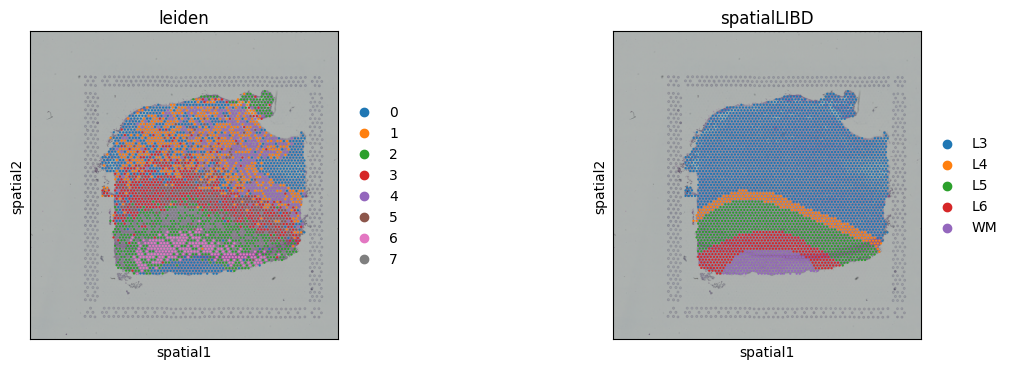

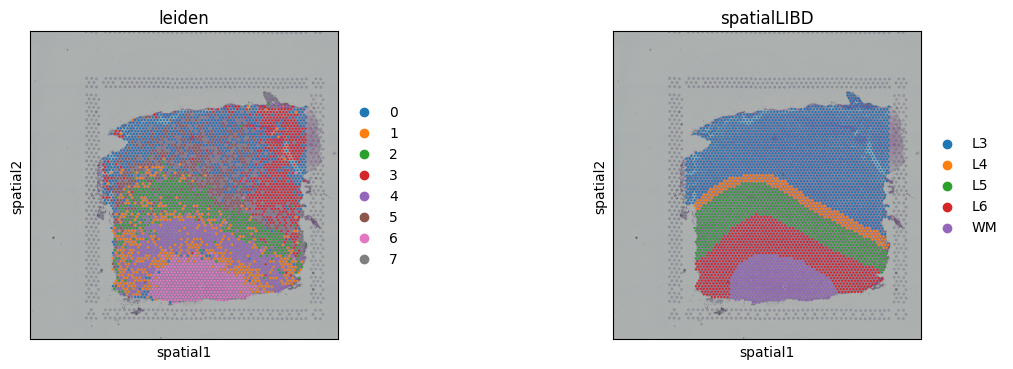

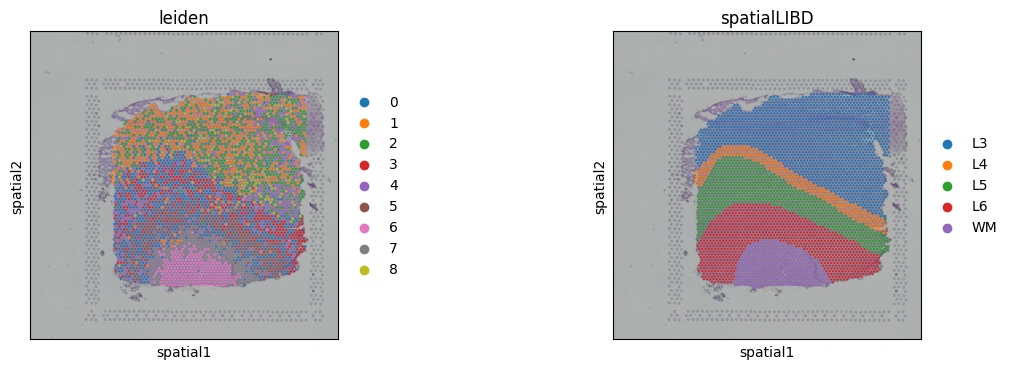

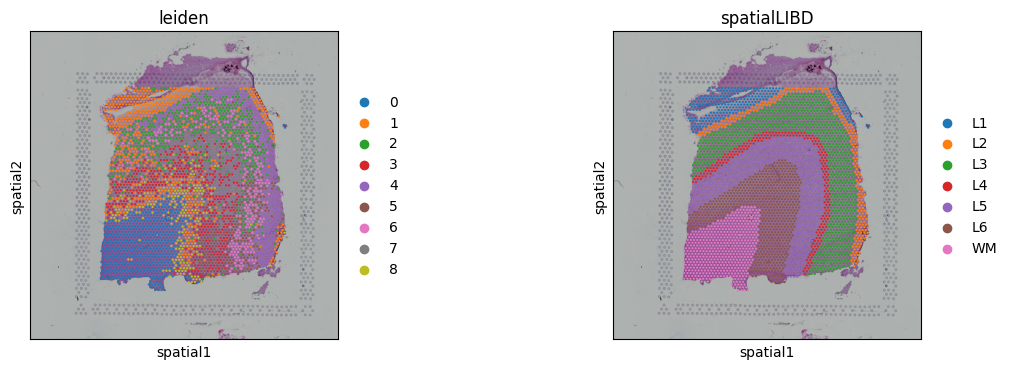

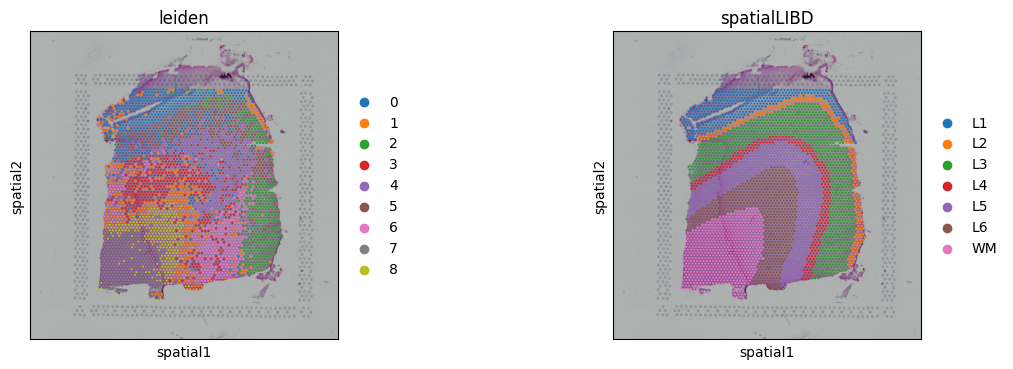

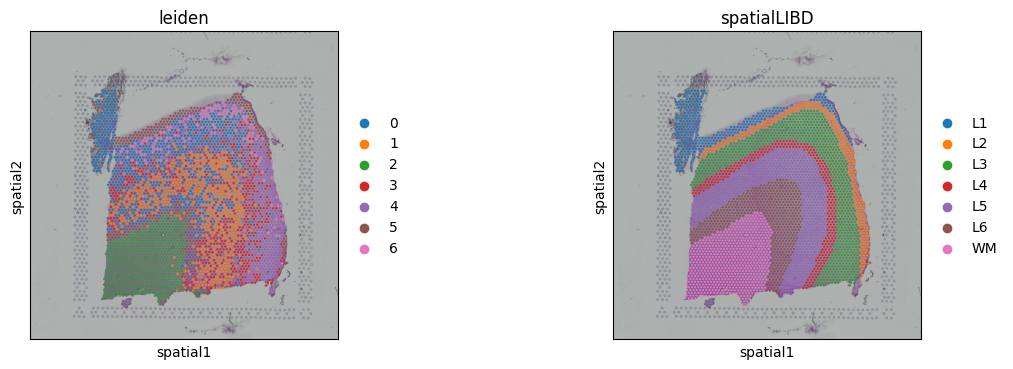

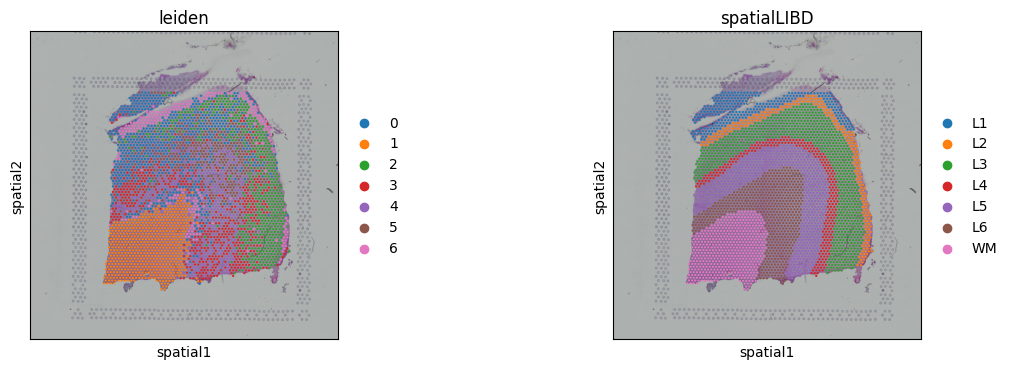

In [5]:
for library_id in library_ids:
    adata = load_data(counts_file=f"./reference/{library_id}_filtered_feature_bc_matrix.h5", 
                      library_id=str(library_id),
                      image_path=f'./reference/{library_id}')

    adata = process_data(adata, df_spatial, library_id)
    
    adata.write_h5ad(filename=f'./reference/{library_id}.h5ad')
    
    sq.pl.spatial_scatter(adata, color=["leiden", "spatialLIBD"], size=1, dpi=100, library_id=str(library_id))